In [1]:
from xml.etree.ElementTree import PI
import pandas as pd
import numpy as np
import missingno as msno # missing values plot
import seaborn as sns # missing plot
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split , cross_val_score, GridSearchCV, KFold # train-test split, cross validation
from sklearn.neighbors import KNeighborsClassifier # knn model
from sklearn.preprocessing import OneHotEncoder, StandardScaler # pre-processing
from sklearn.pipeline import Pipeline # pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, jaccard_score

In [8]:
# airline training dataset
df = pd.DataFrame(pd.read_csv("./data/train.csv"))

# summary statistics
summary = df.describe()
print(summary)

print("dimensions:", df.shape)

                id_1             id            Age  Flight Distance  \
count  103904.000000  103904.000000  103904.000000    103904.000000   
mean    51951.500000   64924.210502      39.379706      1189.448375   
std     29994.645522   37463.812252      15.114964       997.147281   
min         0.000000       1.000000       7.000000        31.000000   
25%     25975.750000   32533.750000      27.000000       414.000000   
50%     51951.500000   64856.500000      40.000000       843.000000   
75%     77927.250000   97368.250000      51.000000      1743.000000   
max    103903.000000  129880.000000      85.000000      4983.000000   

       Inflight wifi service  Departure/Arrival time convenient  \
count          103904.000000                      103904.000000   
mean                2.729683                           3.060296   
std                 1.327829                           1.525075   
min                 0.000000                           0.000000   
25%                 2.000

In [9]:
# rename columns variables
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('/', '_')

# drop variables 
df1 = df.drop(["id_1","id"], axis=1)

print(df1.shape)

(103904, 23)


Gender                                 0
Customer_Type                          0
Age                                    0
Type_of_Travel                         0
Class                                  0
Flight_Distance                        0
Inflight_wifi_service                  0
Departure_Arrival_time_convenient      0
Ease_of_Online_booking                 0
Gate_location                          0
Food_and_drink                         0
Online_boarding                        0
Seat_comfort                           0
Inflight_entertainment                 0
On-board_service                       0
Leg_room_service                       0
Baggage_handling                       0
Checkin_service                        0
Inflight_service                       0
Cleanliness                            0
Departure_Delay_in_Minutes             0
Arrival_Delay_in_Minutes             310
satisfaction                           0
dtype: int64
Gender                               0.00000

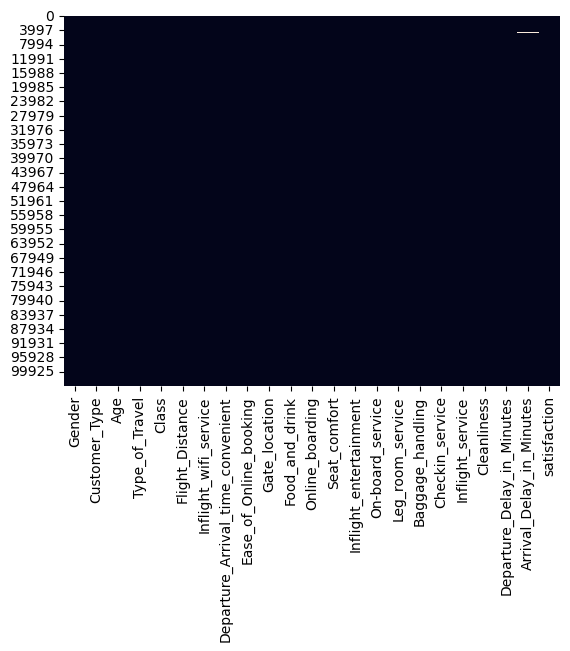

In [10]:
# plot missing NA values
sns.heatmap(df1.isna(), cbar=False)
#plt.show()

# check for NA values
na_count = df1.isna().sum()
print(na_count)
# percentage
na_count_ = df1.isna().sum() / df1.shape[0]
print(na_count_)

In [11]:
# one hot-encoder
encoder = OneHotEncoder(sparse_output=False)
df1_encod= pd.DataFrame(encoder.fit_transform(df1[['Gender', 'Customer_Type', 'Type_of_Travel','Class']]),
                         columns=encoder.get_feature_names_out(['Gender', 'Customer_Type', 'Type_of_Travel','Class'])).reset_index(drop=True)

df2 = df1.drop(['Gender', 'Customer_Type', 'Type_of_Travel','Class'], axis=1).reset_index(drop=True)

# combine dataset with one hot-encoder
df3 = pd.concat([df1_encod, df2], axis=1, ignore_index=True)

# combine the colnames of each dateset
cols = list(df1_encod.columns) + list(df2.columns)

# rename dataset columns
df3.columns = cols

In [12]:
# convert response to 1 or 0
def is_satisfied(satisfaction):
    if satisfaction == "satisfied":
        return 1
    else:
        return 0


df3['is_satisfied'] = df3['satisfaction'].apply(is_satisfied)

df4 = df3.drop(['satisfaction'], axis = 1)


In [13]:
# KNN model for NA value
imputer = KNNImputer(n_neighbors = 5)
df4_imputed = pd.DataFrame(imputer.fit_transform(df4),columns=df4.columns)
#print(df.columns)


# check for NA values
na_count = df4_imputed.isna().sum()
print(na_count)

# convert data type
df4_imputed['is_satisfied'] = df4_imputed['is_satisfied'].astype(int)
print(df4_imputed['is_satisfied'].head())


Gender_Female                        0
Gender_Male                          0
Customer_Type_Loyal Customer         0
Customer_Type_disloyal Customer      0
Type_of_Travel_Business travel       0
Type_of_Travel_Personal Travel       0
Class_Business                       0
Class_Eco                            0
Class_Eco Plus                       0
Age                                  0
Flight_Distance                      0
Inflight_wifi_service                0
Departure_Arrival_time_convenient    0
Ease_of_Online_booking               0
Gate_location                        0
Food_and_drink                       0
Online_boarding                      0
Seat_comfort                         0
Inflight_entertainment               0
On-board_service                     0
Leg_room_service                     0
Baggage_handling                     0
Checkin_service                      0
Inflight_service                     0
Cleanliness                          0
Departure_Delay_in_Minute

In [15]:
# seperate predictors and response
x = df4_imputed.drop('is_satisfied', axis=1)
y = df4_imputed['is_satisfied']

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, balanced_accuracy_score

# decision tree, Boosting and Random Forest Model
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [16]:
# decision tree model 
tree_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier())
], verbose=True)

tree_param = {
    'tree__criterion': ['gini', 'entropy'],
    'tree__max_depth': [3, 5, 10, None],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 4]
}

In [17]:
# tune parameters, fit model on traning set for prediction 
tree_cv = GridSearchCV(tree_pipeline, tree_param, cv = 10, scoring = 'accuracy', n_jobs=-1)
tree_cv.fit(x, y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] .............. (step 2 of 2) Processing tree, total=   1.2s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree', DecisionTreeClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': [3, 5, 10, None],
                         'tree__min_samples_leaf': [1, 2, 4],
                         'tree__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [18]:
# obtain the estimators
tree_best =  tree_cv.best_estimator_.named_steps['tree']

# obtain the predictors 
tree_importances = tree_best.feature_importances_
print(tree_importances)

[6.79286801e-04 6.01500281e-04 1.57615262e-02 3.21525597e-02
 1.98410168e-03 1.32223974e-01 4.58780735e-02 9.21356165e-04
 2.88019393e-04 2.18220696e-02 2.26246307e-02 1.97835862e-01
 3.59225273e-03 1.83778046e-03 2.63673914e-02 3.64298498e-03
 3.15675963e-01 1.66410274e-02 5.15341081e-02 6.31324455e-03
 1.13789918e-02 2.24954022e-02 2.68664712e-02 1.78075191e-02
 9.44696405e-03 5.57274392e-03 8.05419451e-03]


In [54]:
# increase in gini index
variables_names = x.columns.str.replace("_", " ")


var_imp_tree = pd.DataFrame({'Predictors':variables_names, 'gini':tree_importances})
var_imp_tree_sorted = var_imp_tree.sort_values(by = 'gini', ascending=False)
print("Top 5 important predictors for bagging trees model")
print(var_imp_tree_sorted.head(5))

Top 5 important predictors for bagging trees model
                        Predictors      gini
16                 Online boarding  0.315676
11           Inflight wifi service  0.197836
5   Type of Travel Personal Travel  0.132224
18          Inflight entertainment  0.051534
6                   Class Business  0.045878


Text(0.5, 1.0, 'Top 10 Important Features: Decision Tree Model')

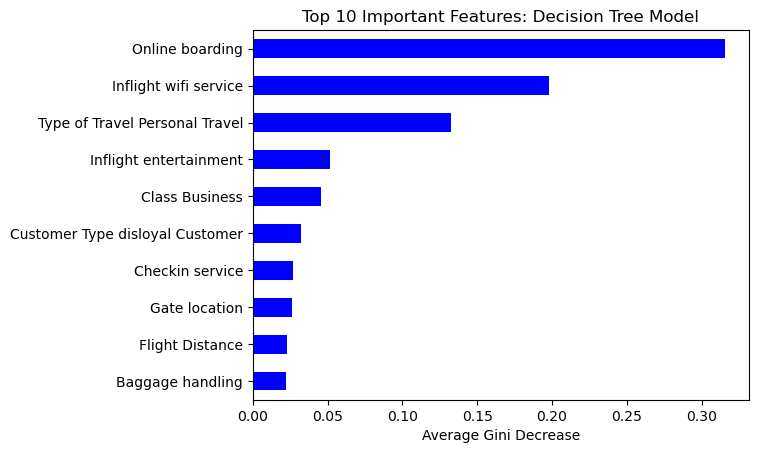

In [56]:
# chart of the important variables
importances = pd.Series(tree_importances, index=variables_names) # series - one dimension array
top_n = 10
top_n_idx = importances.argsort()[-top_n:] # know which features have the highest and lowest importance values
top_n_importances = importances.iloc[top_n_idx] # nteger-location
top_n_importances.plot(kind='barh', color='b')
plt.xlabel('Average Gini Decrease')
plt.title(f'Top {top_n} Important Features: Decision Tree Model')

In [ ]:
var_imp_tree_sorted.head(10).sort_values(by = 'gini').plot(x = 'Predictors', y = 'gini', kind = 'barh', label = '')
plt.legend('')
plt.xlabel('Average Gini Decrease')
plt.title(f'Top {top_n} Important Features: Decision Tree Model')
plt.ylabel('')

In [22]:
# bagging trees model
bagging_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging', BaggingClassifier(estimator=DecisionTreeClassifier()))
], verbose = True)


# parameters bagging
bagging_params = {
    'bagging__n_estimators': [10, 50, 100, 500],
}

# random forest model pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
], verbose=True)

# rf parameters
rf_param = {
    'rf__n_estimators': [10, 50, 100,500],
    'rf__max_depth': [None, 5, 10],
}

#bagging__max_samples - controls the maximum number of samples to draw from the dataset for each base estimator it is a fraction between 0 and 1
# rf_ma_depth - control maximum depth of each decision tree (the number of levels iof trees)

In [23]:
#Fit bagging tree model
bagging_cv = GridSearchCV(bagging_pipeline, param_grid = bagging_params, cv = 10, scoring = 'accuracy', n_jobs=-1)# ,'f1'])
bagging_cv.fit(x, y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing bagging, total= 5.5min


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('bagging',
                                        BaggingClassifier(estimator=DecisionTreeClassifier()))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'bagging__n_estimators': [10, 50, 100, 500]},
             scoring='accuracy')

In [25]:
# obtain the estimators
bagging_best =  bagging_cv.best_estimator_.named_steps['bagging']

In [26]:
# obtain the predictors 
bagging_importances = bagging_best.estimators_[0].feature_importances_
print(bagging_importances)

[0.00166165 0.00115952 0.00655059 0.02885928 0.00515699 0.14320585
 0.01836129 0.00151983 0.0004263  0.02145755 0.02117288 0.17326765
 0.00857242 0.00408082 0.01762406 0.00329661 0.3663751  0.01538637
 0.0490153  0.00965003 0.00991783 0.02324591 0.03042501 0.01420192
 0.00942597 0.00814595 0.00783731]


In [28]:
# %IncMSE/gini percent increase of MSE 
# estimate the importance of each predictor
# by looking at the increase MSE
# when the predictor variable is removed from the model
variables_names = x.columns.str.replace("_", " ")


var_imp_bagg = pd.DataFrame({'Predictors':variables_names, 'gini':bagging_importances})
var_imp_bagg_sorted = var_imp_bagg.sort_values(by = 'gini', ascending=False)
print("Top 5 important predictors for bagging trees model")
print(var_imp_bagg_sorted.head(5))

Top 5 important predictors for bagging trees model
                        Predictors      gini
16                 Online boarding  0.366375
11           Inflight wifi service  0.173268
5   Type of Travel Personal Travel  0.143206
18          Inflight entertainment  0.049015
22                 Checkin service  0.030425


Text(0.5, 1.0, 'Top 10 Important Features: Bagging Decision Tree')

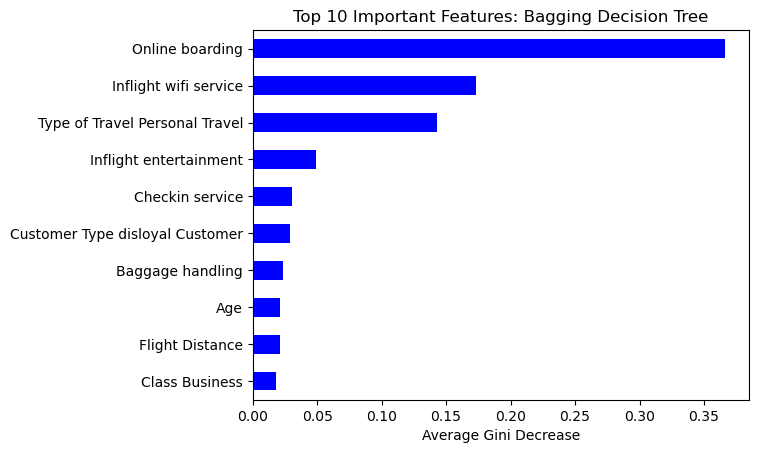

In [53]:
# chart of the important variables
importances = pd.Series(bagging_importances, index=variables_names) # series - one dimension array
top_n = 10
top_n_idx = importances.argsort()[-top_n:] # know which features have the highest and lowest importance values
top_n_importances = importances.iloc[top_n_idx] # nteger-location based indexing of a dataframe or a series
top_n_importances.plot(kind='barh', color='b') # bar chart
plt.xlabel('Average Gini Decrease')
plt.title(f'Top {top_n} Important Features: Bagging Decision Tree')

In [24]:
#Random forest model
rf_cv = GridSearchCV(rf_pipeline, param_grid= rf_param, cv = 10, scoring = 'accuracy', n_jobs=-1)
rf_cv.fit(x, y)


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total= 1.8min


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf', RandomForestClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__n_estimators': [10, 50, 100, 500]},
             scoring='accuracy')

In [30]:
#calculate important predictors

# obtain the estimators
rf_best =  rf_cv.best_estimator_.named_steps['rf']

In [31]:
# obtain the predictors %incmse for RF
rf_importances = rf_best.estimators_[0].feature_importances_
print(rf_importances)

[0.00264262 0.00700005 0.01684529 0.02554638 0.01537821 0.06002306
 0.02481837 0.00827993 0.00153566 0.03991984 0.02413661 0.10369423
 0.01319622 0.03966866 0.01251611 0.01500474 0.36258522 0.01404192
 0.03219208 0.0115939  0.08220565 0.01730116 0.02232144 0.01307531
 0.01112232 0.01227711 0.01107792]


In [33]:
# top five important variables using %IncMSE
variables_names = x.columns.str.replace("_", " ")


var_imp_rf = pd.DataFrame({'Predictors':variables_names, 'gini':rf_importances})
var_imp_rf_sorted = var_imp_rf.sort_values(by = 'gini', ascending=False)
print("Top 5 important predictors for Random Forest trees model")
print(var_imp_rf_sorted.head(5))

Top 5 important predictors for Random Forest trees model
                        Predictors      gini
16                 Online boarding  0.362585
11           Inflight wifi service  0.103694
20                Leg room service  0.082206
5   Type of Travel Personal Travel  0.060023
9                              Age  0.039920


Text(0.5, 1.0, 'Top 10 Important Features: Random Forest')

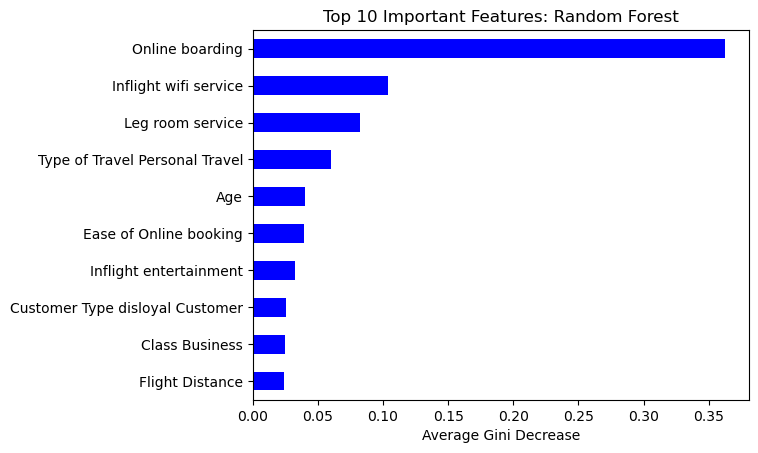

In [34]:
importances = pd.Series(rf_importances, index=variables_names) # series - one dimension array
top_n = 10
top_n_idx = importances.argsort()[-top_n:] # know which features have the highest and lowest importance values
top_n_importances = importances.iloc[top_n_idx] # nteger-location based indexing of a dataframe or a series
top_n_importances.plot(kind='barh', color='b') # bar chart
plt.xlabel('Average Gini Decrease')
plt.title(f'Top {top_n} Important Features: Random Forest')

In [35]:
#boosting
from sklearn.ensemble import GradientBoostingClassifier

# boosting - GradientBoostingClassifier default trees
boost_tree_pipeline =  Pipeline([
    ('scaler', StandardScaler()),
   ('gbt', GradientBoostingClassifier())
], verbose = True)

In [36]:
# parameters
boost_tree_param =  {
   'gbt__learning_rate': [0.1, 0.05, 0.01],
    'gbt__n_estimators': [50, 100, 200],
    'gbt__max_depth': [3, 4, 5]
}

#n_estimators: number of decision trees to include in the ensemble.
#learning_rate: the learning rate shrinks the contribution of each tree by learning_rate amount.
#max_depth: the maximum depth of the decision trees.
#max_features: the number of features to consider when looking for the best split. 
#subsample: the fraction of samples to be used for fitting the individual base learners. Values lower than 1.0 would make the algorithm stochastic.

In [37]:
# fit model & cross validation k-fold
boosting_tree_cv = GridSearchCV(boost_tree_pipeline, param_grid=boost_tree_param, cv = 10, scoring = 'accuracy', n_jobs=-1)
boosting_tree_cv.fit(x, y)


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing gbt, total= 1.0min


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbt', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'gbt__learning_rate': [0.1, 0.05, 0.01],
                         'gbt__max_depth': [3, 4, 5],
                         'gbt__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [38]:
#calculate important predictors

# obtain the estimators
boosting_best =  boosting_tree_cv.best_estimator_.named_steps['gbt']

# obtain the predictors %incmse for RF
boosting_importances = boosting_best.feature_importances_
print(boosting_importances)

[2.13530064e-05 1.37136312e-05 1.77499356e-02 1.19633070e-02
 8.27051872e-02 7.58055630e-02 3.41981773e-02 4.20133706e-05
 2.75943728e-05 6.33621020e-03 3.09859158e-03 2.15901483e-01
 1.17979022e-03 2.73725699e-03 5.29160331e-03 8.13854892e-04
 4.12753835e-01 1.34451990e-02 3.26557851e-02 1.14327795e-02
 1.54631605e-02 9.90139241e-03 2.06357791e-02 1.13746661e-02
 1.08195930e-02 3.77404861e-04 3.25477136e-03]


In [39]:
# top five important variables using %IncMSE
variables_names = x.columns.str.replace("_", " ")


var_imp_boost = pd.DataFrame({'Predictors':variables_names, 'gini':boosting_importances})
var_imp_boost_sorted = var_imp_boost.sort_values(by = 'gini', ascending=False)
print("Top 5 important predictors for bagging trees model")
print(var_imp_boost_sorted.head(5))

Top 5 important predictors for bagging trees model
                        Predictors      gini
16                 Online boarding  0.412754
11           Inflight wifi service  0.215901
4   Type of Travel Business travel  0.082705
5   Type of Travel Personal Travel  0.075806
6                   Class Business  0.034198


Text(0.5, 1.0, 'Top 10 Important Features: Boosting Decision Tree')

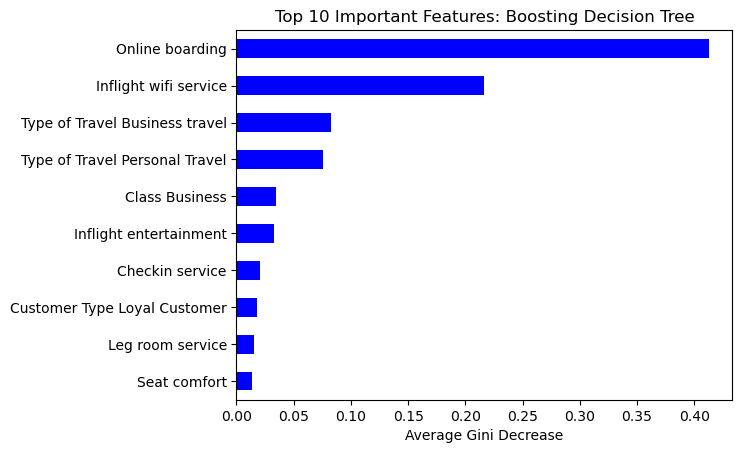

In [40]:
importances = pd.Series(boosting_importances, index=variables_names) # series - one dimension array
top_n = 10
top_n_idx = importances.argsort()[-top_n:] # know which features have the highest and lowest importance values
top_n_importances = importances.iloc[top_n_idx] # nteger-location based indexing of a dataframe or a series
top_n_importances.plot(kind='barh', color='b') # bar chart
plt.xlabel('Average Gini Decrease')
plt.title(f'Top {top_n} Important Features: Boosting Decision Tree')

In [42]:
# logistic Lasso regression
from sklearn.linear_model import LogisticRegression

#logistic
logistic_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('log', LogisticRegression(penalty= 'l1',  solver='saga', max_iter = 2000))
], verbose = True) 

# hyperparameters 
param_grid = {
    'log__class_weight': [None, 'balanced']
}



In [45]:
# fit logistic lasso regression
logistic_cv = GridSearchCV(logistic_pipe, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
logistic_cv.fit(x, y)


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing log, total= 1.6min


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log',
                                        LogisticRegression(max_iter=2000,
                                                           penalty='l1',
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1, param_grid={'log__class_weight': [None, 'balanced']},
             scoring='accuracy')

In [46]:
# Fit grid search object to the data
log_best_params = logistic_cv.best_params_
print(log_best_params)

{'log__class_weight': None}


In [48]:
# coefficient interms of log-odds and odds
from tabulate import tabulate

coeff = logistic_cv.best_estimator_.named_steps['log'].coef_

coef_df = pd.DataFrame({'Variable': x.columns.str.replace("_", " "),
                        'Log-Odds Coefficient': coeff[0],
                        'Odds Ratio coefficient': np.exp(coeff[0]) })


print(tabulate(coef_df.sort_values('Odds Ratio coefficient', ascending= False), headers='keys', tablefmt='psql'))

+----+-----------------------------------+------------------------+--------------------------+
|    | Variable                          |   Log-Odds Coefficient |   Odds Ratio coefficient |
|----+-----------------------------------+------------------------+--------------------------|
| 16 | Online boarding                   |              0.826145  |                 2.28449  |
|  4 | Type of Travel Business travel    |              0.629159  |                 1.87603  |
| 11 | Inflight wifi service             |              0.523638  |                 1.68816  |
| 22 | Checkin service                   |              0.409646  |                 1.50628  |
|  2 | Customer Type Loyal Customer      |              0.393219  |                 1.48174  |
| 19 | On-board service                  |              0.388282  |                 1.47445  |
|  6 | Class Business                    |              0.367945  |                 1.44476  |
| 20 | Leg room service                  |        

In [57]:
# random sample for prediction analysis
df5 = df4_imputed.sample(n= 20000, random_state=1)

# seperate predictors and response
x = df5.drop('is_satisfied', axis=1)
y = df5['is_satisfied']


In [58]:
# 70/30 split training/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=1)

In [11]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

k_val = list(range(1,40))
k_scores = []

for k in k_val:
    pipeline.set_params(knn__n_neighbors=k)
    scores = cross_val_score(pipeline, x_train, y_train, cv = 10, scoring = 'accuracy')
    k_scores.append(scores.mean())


# optimal k values for neighbors knn model 
opt_k = k_val[k_scores.index(max(k_scores))]
print(f"optimal k value:  {opt_k}")

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

optimal k value:  1


C:\Users\sanch\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\pipeline.py", line 481, in predict
    return self.steps[-1][1].predict(Xt, **predict_params)
  File "C:\Users\sanch\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 234, in predict
    neigh_ind 

In [ ]:
# create pipeline for knn 
knn_pipeline = Pipeline([
    #('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_parameter = {
    "knn__n_neighbors" : range(3,30)
}

# cross validation
knn_cv = GridSearchCV(knn_pipeline, param_grid = knn_parameter, cv = 10, n_jobs=-1, scoring='accuracy')# ,'f1'])
knn_cv.fit(x_train, y_train)
knn_cv.best_estimator_
#knn_cv.cv_results_

In [ ]:
# fit knn model to full dataset with k =9
pipeline.set_params(knn__n_neighbors=opt_k)
pipeline.fit(x_train, y_train)

In [ ]:
# predictions
pred_knn = knn_cv.predict(x_test)

# confusion matrix
knn_cm = confusion_matrix(y_test, pred_knn)
print(knn_cm)
print(pd.crosstab(y_test, pred_knn, rownames=['True'], colnames=['Predicted'], margins=True))

sns.heatmap(knn_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.show()

#  confusion matrix
report = classification_report(y_test, pred_knn)

# Print the report
print(report)
knn_accuracy = accuracy_score(y_test, pred_knn).round(2)
knn_precision = precision_score(y_test, pred_knn).round(2)
knn_recall = recall_score(y_test, pred_knn).round(2)
knn_f1 = f1_score(y_test, pred_knn).round(2)
knn_balanced_acc = balanced_accuracy_score(y_test, pred_knn). round(2)

print(f"knn model (k = {opt_k}): accuracy: {knn_accuracy}, precision: {knn_precision}, recal: {knn_recall}, f1 score: {knn_f1}", 'Balanced Accuracy: ' {knn_balanced_acc})

In [63]:
# decision tree model
# tune parameters, fit model on traning set for prediction 
tree_cv = GridSearchCV(tree_pipeline, tree_param, cv = 10, scoring = 'accuracy', n_jobs=-1)
tree_cv.fit(x_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .............. (step 2 of 2) Processing tree, total=   0.1s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree', DecisionTreeClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': [3, 5, 10, None],
                         'tree__min_samples_leaf': [1, 2, 4],
                         'tree__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [64]:
#predictions on test set
tree_cv.best_estimator_

tree_pred = tree_cv.predict(x_test)

In [65]:
# confusion matrix
print(pd.crosstab(y_test, tree_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted     0     1   All
True                       
0          3274   173  3447
1           208  2345  2553
All        3482  2518  6000


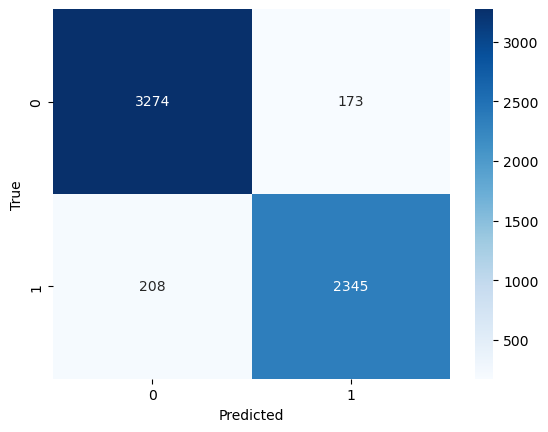

In [66]:
# heatmap of results

tree_cm = confusion_matrix(y_test, tree_pred)
sns.heatmap(tree_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [138]:
#  confusion matrix
report = classification_report(y_test, tree_pred)

# Print the report
print(report)
t_accuracy = accuracy_score(y_test, tree_pred).round(2)
t_precision = precision_score(y_test, tree_pred).round(2)
t_recall = recall_score(y_test, tree_pred).round(2)
t_f1 = f1_score(y_test, tree_pred).round(2)
t_balanced_acc = balanced_accuracy_score(y_test, tree_pred). round(2)


print(f"Decision tree model: accuracy: {t_accuracy}, precision: {t_precision}, recall: {t_recall}, f1 score: {t_f1}, balanced accuracy {t_balanced_acc}")

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3447
           1       0.93      0.92      0.92      2553

    accuracy                           0.94      6000
   macro avg       0.94      0.93      0.93      6000
weighted avg       0.94      0.94      0.94      6000

Decision tree model: accuracy: 0.94, precision: 0.93, recall: 0.92, f1 score: 0.92, balanced accuracy 0.93


In [72]:
# cross validation bagging model
bagging_cv = GridSearchCV(bagging_pipeline, param_grid = bagging_params, cv = 10, scoring = 'accuracy', n_jobs=-1)# ,'f1'])
bagging_cv.fit(x_train, y_train)


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing bagging, total=  29.2s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('bagging',
                                        BaggingClassifier(estimator=DecisionTreeClassifier()))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'bagging__n_estimators': [10, 50, 100, 500]},
             scoring='accuracy')

In [73]:
# cross validation rf model 
rf_cv = GridSearchCV(rf_pipeline, param_grid= rf_param, cv = 10, scoring = 'accuracy', n_jobs=-1)
rf_cv.fit(x_train, y_train)


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   9.4s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf', RandomForestClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__n_estimators': [10, 50, 100, 500]},
             scoring='accuracy')

In [75]:
# parameters of n trees bagging
bagging_best_params = bagging_cv.best_params_
print(bagging_best_params)


# parameters of rf 
rf_best_params = rf_cv.best_params_
print(rf_best_params)


{'bagging__n_estimators': 500}
{'rf__max_depth': None, 'rf__n_estimators': 500}


In [76]:
# prediction on test dataset using bagging model
pred_bagging = bagging_cv.predict(x_test)

In [77]:
bagging_cm = confusion_matrix(y_test, pred_bagging)
print(pd.crosstab(y_test, pred_bagging, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted     0     1   All
True                       
0          3333   114  3447
1           175  2378  2553
All        3508  2492  6000


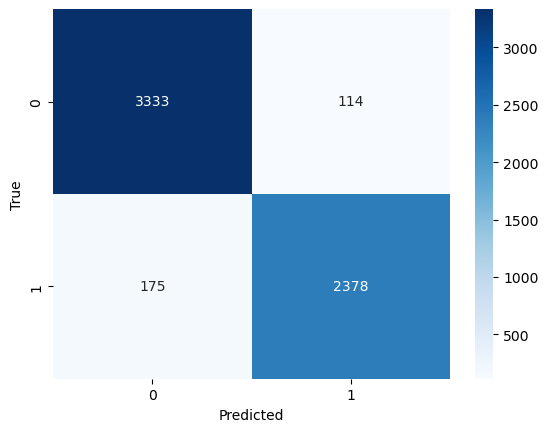

In [78]:
# heatmap of results
sns.heatmap(bagging_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [137]:
#  confusion matrix
report = classification_report(y_test, pred_bagging)

# Print the report
print(report)
bag_accuracy = accuracy_score(y_test, pred_bagging).round(2)
bag_precision = precision_score(y_test, pred_bagging).round(2)
bag_recall = recall_score(y_test, pred_bagging).round(2)
bag_f1 = f1_score(y_test, pred_bagging).round(2)
bag_balanced_acc = balanced_accuracy_score(y_test, pred_bagging). round(2)


print(f"Decision tree model: accuracy: {bag_accuracy}, precision: {bag_precision}, recall: {bag_recall}, f1 score: {bag_f1}, Balanced accuracy {bag_balanced_acc}")

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3447
           1       0.95      0.93      0.94      2553

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000

Decision tree model: accuracy: 0.95, precision: 0.95, recall: 0.93, f1 score: 0.94, Balanced accuracy 0.95


In [80]:
# random forest predicitons
pred_rf = rf_cv.predict(x_test)

In [81]:
rf_cm = confusion_matrix(y_test, pred_rf)
print(pd.crosstab(y_test, pred_rf, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted     0     1   All
True                       
0          3357    90  3447
1           177  2376  2553
All        3534  2466  6000


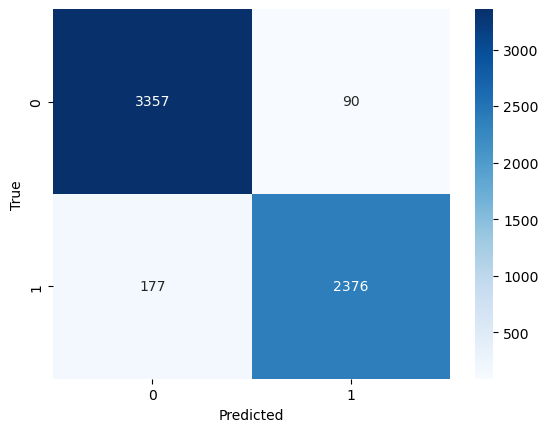

In [82]:
# heatmap of results
sns.heatmap(rf_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [136]:
#  confusion matrix
report_rf = classification_report(y_test, pred_rf)

# Print the report
print(report_rf)
rf_accuracy = accuracy_score(y_test, pred_rf).round(2)
rf_precision = precision_score(y_test, pred_rf).round(2)
rf_recall = recall_score(y_test, pred_rf).round(2)
rf_f1 = f1_score(y_test, pred_rf).round(2)
rf_balanced_acc = balanced_accuracy_score(y_test, pred_rf). round(2)

print(f"Decision tree model: accuracy: {rf_accuracy}, precision: {rf_precision}, recall: {rf_recall}, f1 score: {rf_f1}, Balanced accuracy {rf_balanced_acc}")

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3447
           1       0.96      0.93      0.95      2553

    accuracy                           0.96      6000
   macro avg       0.96      0.95      0.95      6000
weighted avg       0.96      0.96      0.96      6000

Decision tree model: accuracy: 0.96, precision: 0.96, recall: 0.93, f1 score: 0.95, Balanced accuracy 0.95


In [84]:
# boosting model
# fit model & cross validation k-fold
boosting_tree_cv = GridSearchCV(boost_tree_pipeline, param_grid=boost_tree_param, cv = 10, scoring = 'accuracy', n_jobs=-1)
boosting_tree_cv.fit(x_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing gbt, total=   8.4s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gbt', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'gbt__learning_rate': [0.1, 0.05, 0.01],
                         'gbt__max_depth': [3, 4, 5],
                         'gbt__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [85]:
# parameters of boosting 
boost_best_params = boosting_tree_cv.best_params_
print(boost_best_params)

#{'gbt__learning_rate': 0.1, 'gbt__max_depth': 6, 'gbt__n_estimators': 200}


{'gbt__learning_rate': 0.1, 'gbt__max_depth': 5, 'gbt__n_estimators': 200}


In [86]:
# prediction on test dataset using bagging model
pred_boosting = boosting_tree_cv.predict(x_test)

In [87]:
print(pd.crosstab(y_test, pred_boosting, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted     0     1   All
True                       
0          3363    84  3447
1           165  2388  2553
All        3528  2472  6000


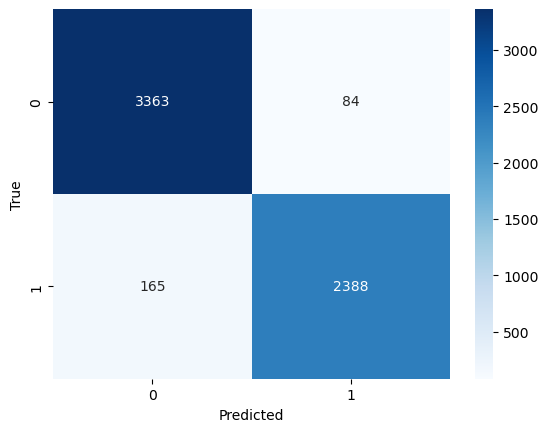

In [88]:
# heatmap of results
boosting_cm = confusion_matrix(y_test, pred_boosting) # matrix

sns.heatmap(boosting_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [135]:
#  confusion matrix
report_boosting = classification_report(y_test, pred_boosting)

# Print the report
print(report_boosting)
boost_accuracy = accuracy_score(y_test, pred_boosting).round(2)
boost_precision = precision_score(y_test, pred_boosting).round(2)
boost_recall = recall_score(y_test, pred_boosting).round(2)
boost_f1 = f1_score(y_test, pred_boosting).round(2)
boost_balanced_acc = balanced_accuracy_score(y_test, pred_boosting). round(2)


print(f"Decision tree model: accuracy: {boost_accuracy}, precision: {boost_precision}, recall: {boost_recall}, f1 score: {boost_f1}, Balanced accuracy {boost_balanced_acc}")

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3447
           1       0.97      0.94      0.95      2553

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

Decision tree model: accuracy: 0.96, precision: 0.97, recall: 0.94, f1 score: 0.95, Balanced accuracy 0.96


In [90]:
# SVM
from sklearn.svm import SVC

In [91]:
# SVM MODEL
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
], verbose=True)

# svm parameter
svm_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'poly','rbf'],
    'svm__gamma': [0.1, 1, 10 ]
}

In [92]:
# fit model & cross validation k-fold
svm_cv = GridSearchCV(svm_pipeline, param_grid=svm_grid, cv = 10, scoring = 'accuracy', n_jobs=-1)
svm_cv.fit(x_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svm, total=  23.1s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(probability=True))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10], 'svm__gamma': [0.1, 1, 10],
                         'svm__kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [93]:
# parameters of svm
svm_best_params = svm_cv.best_params_
print(svm_best_params)


{'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [94]:
# prediction on test dataset using svm model
pred_svm = svm_cv.predict(x_test)


In [95]:
print(pd.crosstab(y_test, pred_svm, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted     0     1   All
True                       
0          3331   116  3447
1           220  2333  2553
All        3551  2449  6000


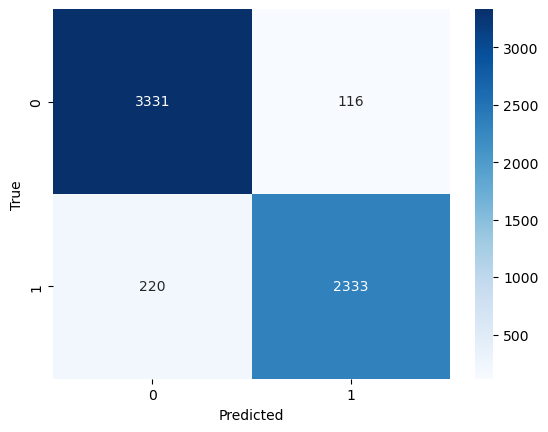

In [96]:
# heatmap of results
svm_cm = confusion_matrix(y_test, pred_svm) # matrix

sns.heatmap(svm_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [134]:
#  confusion matrix
report_svm = classification_report(y_test, pred_svm)

# Print the report
print(report_svm)
svm_accuracy = accuracy_score(y_test, pred_svm).round(2)
svm_precision = precision_score(y_test, pred_svm).round(2)
svm_recall = recall_score(y_test, pred_svm).round(2)
svm_f1 = f1_score(y_test, pred_svm).round(2)
svm_balanced_acc = balanced_accuracy_score(y_test, pred_svm). round(2)


print(f"SVM model: accuracy: {svm_accuracy}, precision: {svm_precision}, recall: {svm_recall}, f1 score: {svm_f1}, balanced accuracy {svm_balanced_acc}")

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3447
           1       0.95      0.91      0.93      2553

    accuracy                           0.94      6000
   macro avg       0.95      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000

SVM model: accuracy: 0.94, precision: 0.95, recall: 0.91, f1 score: 0.93, balanced accuracy 0.94


In [98]:
# Fit grid search object to the data
log_best_params = logistic_cv.best_params_
print(log_best_params)


{'log__class_weight': None}


In [99]:
# predict on test set
pred_log = logistic_cv.predict(x_test)

In [100]:
print(pd.crosstab(y_test, pred_log, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted     0     1   All
True                       
0          3119   328  3447
1           392  2161  2553
All        3511  2489  6000


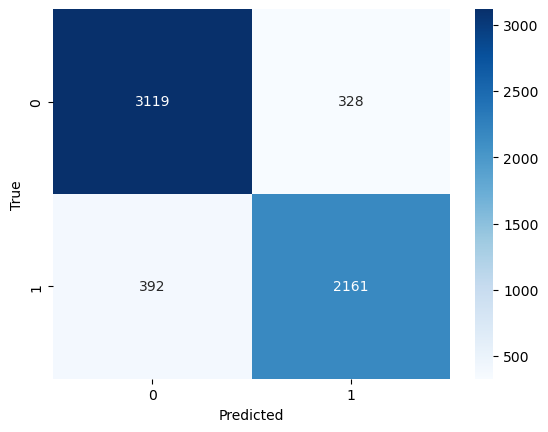

In [101]:
# heatmap of results
log_cm = confusion_matrix(y_test, pred_log) # matrix

sns.heatmap(log_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [133]:
#  confusion matrix
report_log = classification_report(y_test, pred_log)

# Print the report
print(report_log)
log_accuracy = accuracy_score(y_test, pred_log).round(2)
log_precision = precision_score(y_test, pred_log).round(2)
log_recall = recall_score(y_test, pred_log).round(2)
log_f1 = f1_score(y_test, pred_log).round(2)
log_balanced_acc = balanced_accuracy_score(y_test, pred_log). round(2)


print(f"Logistic Lasso Regression model: accuracy: {log_accuracy}, precision: {log_precision}, recall: {log_recall}, f1 score: {log_f1}, balanced accuracy {log_balanced_acc}")

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      3447
           1       0.87      0.85      0.86      2553

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000

Logistic Lasso Regression model: accuracy: 0.88, precision: 0.87, recall: 0.85, f1 score: 0.86, balanced accuracy 0.88


In [149]:
#AUC curve
from sklearn.metrics import roc_curve, auc

# probabilites on test set logisitc
log_y_prob = logistic_cv.predict_proba(x_test)[:, 1]
log_fpr, log_tpr, log_thresholds = roc_curve(y_test, log_y_prob)
log_roc_auc = auc(log_fpr, log_tpr)

# decision tree
tree_y_prob = tree_cv.predict_proba(x_test)[:, 1]
tree_fpr, tree_tpr, tree_thresholds = roc_curve(y_test, tree_y_prob)
tree_roc_auc = auc(tree_fpr, tree_tpr)

# bagging trees
bagging_y_prob = bagging_cv.predict_proba(x_test)[:, 1]
bagging_fpr, bagging_tpr, bagging_thresholds = roc_curve(y_test, bagging_y_prob)
bagging_roc_auc = auc(bagging_fpr, bagging_tpr)

# Boosting trees
boosting_y_prob = boosting_tree_cv.predict_proba(x_test)[:, 1]
boosting_fpr, boosting_tpr, boosting_thresholds = roc_curve(y_test, boosting_y_prob)
boosting_roc_auc = auc(boosting_fpr, boosting_tpr)

# Random Forest
rf_y_prob = rf_cv.predict_proba(x_test)[:, 1]
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_y_prob)
rf_roc_auc = auc(rf_fpr, rf_tpr)

# SVM
svm_y_prob = svm_cv.predict_proba(x_test)[:, 1]
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm_y_prob)
svm_roc_auc = auc(svm_fpr, svm_tpr)

print(f"Logistic AUC: {log_roc_auc.round(2)}")
print(f"Decision tree AUC: {tree_roc_auc.round(2)}")
print(f"Bagging Decision tree AUC: {bagging_roc_auc.round(2)}")
print(f"Boosting Decision tree AUC: {boosting_roc_auc.round(2)}")
print(f"Random Forest AUC: {rf_roc_auc.round(2)}")
print(f"SVM AUC: {svm_roc_auc.round(2)}")

Logistic AUC: 0.93
Decision tree AUC: 0.97
Bagging Decision tree AUC: 0.99
Boosting Decision tree AUC: 0.99
Random Forest AUC: 0.99
SVM AUC: 0.98


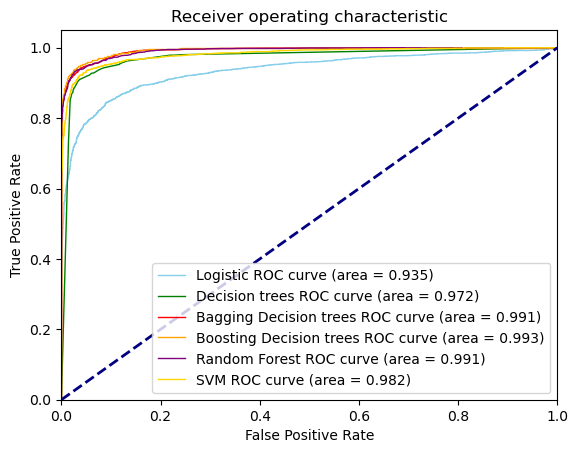

In [104]:
# Plot ROC curve
plt.figure()
plt.plot(log_fpr, log_tpr, color='skyblue', lw=1, label='Logistic ROC curve (area = %0.3f)' % log_roc_auc)
plt.plot(tree_fpr, tree_tpr, color='green', lw=1, label='Decision trees ROC curve (area = %0.3f)' % tree_roc_auc)
plt.plot(bagging_fpr, bagging_tpr, color='red', lw=1, label='Bagging Decision trees ROC curve (area = %0.3f)' % bagging_roc_auc)
plt.plot(boosting_fpr, boosting_tpr, color='orange', lw=1, label='Boosting Decision trees ROC curve (area = %0.3f)' % boosting_roc_auc)
plt.plot(rf_fpr, rf_tpr, color='purple', lw=1, label='Random Forest ROC curve (area = %0.3f)' % rf_roc_auc)
plt.plot(svm_fpr, svm_tpr, color='gold', lw=1, label='SVM ROC curve (area = %0.3f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [150]:
# performance metrics table

tb = {
    'Models'   : ['Boosting Decision tree', 'Random Forest', 'Bagging Decision tree', 'SVM', 'Decision tree', 'KNN', 'Logistic Lasso Regression'],
    "Accuracy" : [boost_accuracy, rf_accuracy, bag_accuracy, svm_accuracy, t_accuracy, 0.91 ,log_accuracy],
    'Precision': [boost_precision, rf_precision, bag_precision, svm_precision, t_precision, 0.94, log_precision],
    'Recall'   : [boost_recall,  rf_recall, bag_recall, svm_recall, t_recall, 0.85,log_recall],
    'F1 Score' : [boost_f1,  rf_f1, bag_f1, svm_f1, t_f1, 0.89,log_f1],
    'Balanced accuracy' : [boost_balanced_acc, rf_balanced_acc, bag_balanced_acc, svm_balanced_acc, t_balanced_acc, 0.91 ,log_balanced_acc]
}

tb_df = pd.DataFrame(tb)
print(tb_df.to_markdown(index = False))

| Models                    |   Accuracy |   Precision |   Recall |   F1 Score |   Balanced accuracy |
|:--------------------------|-----------:|------------:|---------:|-----------:|--------------------:|
| Boosting Decision tree    |       0.96 |        0.97 |     0.94 |       0.95 |                0.96 |
| Random Forest             |       0.96 |        0.96 |     0.93 |       0.95 |                0.95 |
| Bagging Decision tree     |       0.95 |        0.95 |     0.93 |       0.94 |                0.95 |
| SVM                       |       0.94 |        0.95 |     0.91 |       0.93 |                0.94 |
| Decision tree             |       0.94 |        0.93 |     0.92 |       0.92 |                0.93 |
| KNN                       |       0.91 |        0.94 |     0.85 |       0.89 |                0.91 |
| Logistic Lasso Regression |       0.88 |        0.87 |     0.85 |       0.86 |                0.88 |


In [139]:
print(f"Bagging Decision tree model: accuracy: {bag_accuracy}, precision: {bag_precision}, recall: {bag_recall}, f1 score: {bag_f1}, Balanced accuracy {bag_balanced_acc}")
print(f"Boosting Decision tree model: accuracy: {boost_accuracy}, precision: {boost_precision}, recall: {boost_recall}, f1 score: {boost_f1}, Balanced accuracy {boost_balanced_acc}")
print(f"Random Forest model: accuracy: {rf_accuracy}, precision: {rf_precision}, recall: {rf_recall}, f1 score: {rf_f1}, Balanced accuracy {rf_balanced_acc}")


print(f"Decision tree model: accuracy: {t_accuracy}, precision: {t_precision}, recall: {t_recall}, f1 score: {t_f1}, balanced accuracy {t_balanced_acc}")
print(f"SVM model: accuracy: {svm_accuracy}, precision: {svm_precision}, recall: {svm_recall}, f1 score: {svm_f1}, balanced accuracy {svm_balanced_acc}")
print(f"Logistic Lasso Regression model: accuracy: {log_accuracy}, precision: {log_precision}, recall: {log_recall}, f1 score: {log_f1}, balanced accuracy {log_balanced_acc}")

Bagging Decision tree model: accuracy: 0.95, precision: 0.95, recall: 0.93, f1 score: 0.94, Balanced accuracy 0.95
Boosting Decision tree model: accuracy: 0.96, precision: 0.97, recall: 0.94, f1 score: 0.95, Balanced accuracy 0.96
Random Forest model: accuracy: 0.96, precision: 0.96, recall: 0.93, f1 score: 0.95, Balanced accuracy 0.95
Decision tree model: accuracy: 0.94, precision: 0.93, recall: 0.92, f1 score: 0.92, balanced accuracy 0.93
SVM model: accuracy: 0.94, precision: 0.95, recall: 0.91, f1 score: 0.93, balanced accuracy 0.94
Logistic Lasso Regression model: accuracy: 0.88, precision: 0.87, recall: 0.85, f1 score: 0.86, balanced accuracy 0.88
